In [25]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib as mp
import matplotlib.pyplot as plt

In [26]:
method_rename_dict = {
        'velocyto': "Velocyto",
        'scvelo_dyn': "scVelo (dyn)",
        'scvelo_stc': "scVelo (stc)",
        'veloae': "VeloAE",
        'dynamo_m1': "Dynamo (m1)",
        'unitvelo_ind': "UniTVelo (ind)",
        'unitvelo_uni': "UniTVelo (uni)",
        'velovae_std': "VeloVAE",
        'velovae_fullvb': "VeloVAE (Full VB)",
        'deepvelo': "DeepVelo",
        'celldancer': "cellDancer",
        'pyrovelocity_m1': "Pyro-Velocity (m1)",
        'pyrovelocity_m2': "Pyro-Velocity (m2)",
        'kvelo': "κ-velo",
        'velovi': "veloVI",
        'cell2fate': "cell2fate",
        'sdevelo': "SDEvelo",
        'svelvetvae': "SvelvetVAE",
        'latentvelo_std': "LatentVelo (std)",
        'tivelo_std': "TIVelo (std)",
        'tivelo_simple': "TIVelo (simple)",
        'sctour_mse': "scTour (MSE)",
        'sctour_nb': "scTour (NB)",
        'sctour_zinb': "scTour (ZINB)",
        'velvetvae': "VelvetVAE",
        'graphvelo_std': "GraphVelo (std)"
}

dataset_rename_dict = {
    'data01': "Data 1",
    'data02': "Data 2",
    'data03': "Data 3",
    'data04': "Data 4",
    'data05': "Data 5",
    'data06': "Data 6"
}

In [27]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
import matplotlib.lines as mlines


def plot_method_dataset_bubble(
    concat_df: pd.DataFrame,
    method_col: str = "Method",
    dataset_col: str = "dataset",
    value_col: str = "dataset_mean",   # Value for bar length & color (mean)
    size_col: str = "dataset_std",     # Standard deviation used for error bars
    method_order: List[str] = None,    # ✅ Required: Specify method order (top to bottom)
    dataset_order: List[str] = None,   # ✅ Required: Specify dataset order (left to right)
    cmap: str = "viridis",
    vmin: Optional[float] = None,
    vmax: Optional[float] = None,
    size_min: float = 50,              # ✅ Kept for compatibility (not used in this implementation)
    size_max: float = 1200,            # ✅ Kept for compatibility (not used in this implementation)
    annotate: bool = False,
    ann_fmt: str = "{:.2f}",
    figsize: Optional[Tuple[float, float]] = None,
    title: Optional[str] = None,
    size_transform: str = "sqrt",      # ✅ Kept for compatibility (not used in this implementation)
    size_clip: Tuple[float, float] = (0.05, 0.95),  # ✅ Kept for compatibility (not used in this implementation)
    row_stripes: bool = True,
    stripe_light: float = 0.95,
    stripe_contrast: float = 0.08,
    column_spacing: float = 1.0,       # ✅ Kept for compatibility (not used in this implementation)
    trim_to_span: bool = True,         # ✅ Kept for compatibility (not used in this implementation)
    return_span: bool = False,         # ✅ Kept for compatibility (returns a placeholder span)
    size_domain: Optional[Tuple[float, float]] = None,  # ✅ Kept for compatibility (not used in this implementation)
    size_ref_values: Optional[np.ndarray] = None,       # ✅ Kept for compatibility (not used in this implementation)
    size_reverse: bool = True,         # ✅ Kept for compatibility (not used in this implementation)
    colors: List[str] = None,
    bar_outline: bool = True,
):
    # === Parameter Check ===
    if not method_order or not isinstance(method_order, list):
        raise ValueError("method_order must be a non-empty List[str] to explicitly specify the row order of methods.")
    if not dataset_order or not isinstance(dataset_order, list):
        raise ValueError("dataset_order must be a non-empty List[str] to explicitly specify the column order of datasets.")

    df = concat_df.copy()
    df = df[df[method_col].isin(method_order) & df[dataset_col].isin(dataset_order)].copy()
    if df.empty:
        raise ValueError("No data available for plotting after filtering. Please check if method_order and dataset_order match.")

    # === Color Mapping ===
    vals_all = df[value_col].astype(float).values
    vmin = np.nanmin(vals_all) if vmin is None else vmin
    vmax = np.nanmax(vals_all) if vmax is None else vmax
    if not np.isfinite(vmin):
        vmin = 0.0
    if not np.isfinite(vmax):
        vmax = vmin + 1.0
    if vmin == vmax:
        vmax = vmin + 1e-9

    colors = colors
    cmap_obj = LinearSegmentedColormap.from_list("custom", colors, N=256)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)

    # === Organize into Matrix and Align by Order ===
    methods = list(method_order)
    datasets = list(dataset_order)

    # Independent x-axis range for each column (dataset)
    xlims = {}
    for d in datasets:
        sub = df[df[dataset_col] == d]
        means = sub[value_col].astype(float).to_numpy()
        stds = sub[size_col].astype(float).to_numpy()
        stds = np.where(np.isnan(stds), 0.0, stds)
        if means.size == 0:
            lo, hi = 0.0, 1.0
        else:
            lo = np.nanmin(means - stds)
            hi = np.nanmax(means + stds)
        if not np.isfinite(lo):
            lo = 0.0
        if not np.isfinite(hi):
            hi = 1.0
        if np.isclose(lo, hi):
            lo -= 0.1
            hi += 0.1
        pad = (hi - lo) * 0.05
        xlims[d] = (lo - pad, hi + pad)

    # === Figure and Grid ===
    n_rows = len(methods)
    n_cols = len(datasets)
    n_cols_gs = n_cols + 1   # ✅ Add one extra column as a blank placeholder (Column 0)

    if figsize is None:
        fig_w = max(6.5, n_cols_gs * 1.2 + 2.0)  # ✅ Width calculated based on total number of columns
        fig_h = max(4.5, n_rows * 0.45 + 1.5)
        figsize = (fig_w, fig_h)

    plt.rcParams['axes.facecolor'] = 'none'
    fig = plt.figure(figsize=figsize, dpi=300)
    gs = GridSpec(n_rows, n_cols_gs, figure=fig, wspace=0.05, hspace=0.05)

    # === Row Stripe Background (Automatically extends to method name column + blank column) ===
    if row_stripes:
        light_v = max(0.0, min(1.0, stripe_light))
        dark_v = max(0.0, min(1.0, light_v - stripe_contrast))
        row_bg_light = (light_v, light_v, light_v)
        row_bg_dark = (dark_v, dark_v, dark_v)

        # ✅ The first barplot column is now at gs[:, 1]; use it to estimate label area width
        bbox_first = gs[0, 1].get_position(fig)
        label_width = bbox_first.width * 1.5
        x_left = bbox_first.x0 - label_width  # Leftmost position of method names
        x_left -= 0.1

        for i in range(n_rows):
            bbox = gs[i, :].get_position(fig)  # ✅ Includes blank column + all data columns
            band_color = row_bg_light if (i % 2 == 0) else row_bg_dark
            fig.patches.append(
                Rectangle(
                    (x_left, bbox.y0),
                    bbox.x1 - x_left,  # ✅ Covers: method name column + blank column + all bar columns
                    bbox.height,
                    transform=fig.transFigure,
                    color=band_color,
                    zorder=-50,
                    lw=0,
                )
            )
            if i < n_rows - 1:
                next_bbox = gs[i + 1, :].get_position(fig)
                y_line = (bbox.y0 + next_bbox.y1) / 2
                fig.lines.append(
                    mlines.Line2D(
                        [x_left, bbox.x1],
                        [y_line, y_line],
                        transform=fig.transFigure,
                        color="#e6e6e6",
                        linewidth=1.2,
                        zorder=-40,
                    )
                )

        # Outer frame (includes method names + blank column + all bar columns)
        top_bbox = gs[0, :].get_position(fig)
        bottom_bbox = gs[n_rows - 1, :].get_position(fig)
        fig.lines.append(
            mlines.Line2D(
                [x_left, top_bbox.x1],
                [top_bbox.y1, top_bbox.y1],
                transform=fig.transFigure,
                color="#e6e6e6",
                linewidth=1.2,
                zorder=-30,
            )
        )
        fig.lines.append(
            mlines.Line2D(
                [x_left, bottom_bbox.x1],
                [bottom_bbox.y0, bottom_bbox.y0],
                transform=fig.transFigure,
                color="#e6e6e6",
                linewidth=1.2,
                zorder=-30,
            )
        )
        fig.lines.append(
            mlines.Line2D(
                [x_left, x_left],
                [bottom_bbox.y0, top_bbox.y1],
                transform=fig.transFigure,
                color="#e6e6e6",
                linewidth=1.2,
                zorder=-30,
            )
        )
        fig.lines.append(
            mlines.Line2D(
                [top_bbox.x1, top_bbox.x1],
                [bottom_bbox.y0, top_bbox.y1],
                transform=fig.transFigure,
                color="#e6e6e6",
                linewidth=1.2,
                zorder=-30,
            )
        )

    # === Plot Bars + Error Bars Cell by Cell ===
    axs = np.empty((n_rows, n_cols), dtype=object)  # ✅ What is returned to the user is still n_cols (excluding the blank column)

    for i, m in enumerate(methods):
        for j, d in enumerate(datasets):
            # ✅ The actual barplot is placed in column j+1; column 0 is left blank
            ax = fig.add_subplot(gs[i, j + 1])
            ax.set_facecolor("none")
            axs[i, j] = ax

            sub = df[(df[method_col] == m) & (df[dataset_col] == d)]
            if sub.empty:
                ax.axis("off")
                continue

            mean = float(sub[value_col].iloc[0])
            std = float(sub[size_col].iloc[0]) if pd.notna(sub[size_col].iloc[0]) else np.nan
            color = cmap_obj(norm(mean))

            if bar_outline:
                edgecolor = "black"
                linewidth = 0.3
            else:
                edgecolor = "none"
                linewidth = 0.0

            ax.barh(
                [0],
                [mean],
                height=1.0,
                color=color,
                alpha=1.0,
                edgecolor=edgecolor,
                linewidth=linewidth,
            )

            if np.isfinite(std):
                ax.errorbar(
                    [mean],
                    [0],
                    xerr=[[std], [std]],
                    fmt="none",
                    ecolor="black",
                    elinewidth=0.8,
                    capsize=2.5,
                )

            lo, hi = xlims[d]
            ax.set_xlim(lo, hi)
            ax.set_ylim(-0.8, 0.8)
            ax.set_xticks([])
            ax.set_yticks([])
            for sp in ax.spines.values():
                sp.set_visible(False)

            if annotate and np.isfinite(mean):
                ha = "left" if mean < 0 else "right"
                offset = (hi - lo) * 0.01
                x_txt = mean - offset if mean > 0 else mean + offset
                ax.text(
                    x_txt,
                    0,
                    ann_fmt.format(mean),
                    ha=ha,
                    va="center",
                    fontsize=8,
                    color="black",
                )

    # === Method Names on the Left (Still based on the position of the first barplot column) ===
    for i, m in enumerate(methods):
        left_ax = axs[i, 0]
        if left_ax is not None:
            bbox = left_ax.get_position()
            fig.text(
                bbox.x0 - 0.165,          # Still leave some spacing for the "Method Name Column"
                (bbox.y0 + bbox.y1) / 2,
                str(m),
                ha="center",
                va="center",
                fontsize=8,
            )

    if title:
        fig.suptitle(
            title,
            y=0.995,
            fontsize=10,
        )

    if return_span:
        span = (0.0, float(n_cols))
        return fig, axs, span

    return fig, axs

## Aggregate scores

In [28]:
datasets = ['data01', 
            'data02', 
            'data03', 
            'data04', 
            'data05',
            'data06']
metric_name = 'cbdir'

In [29]:
all_scores = []
for dataset in datasets:
    df = pd.read_csv( Path(dataset) / f"{metric_name}_df.csv")
    if metric_name == 'cbdir':
        df.iloc[:, 1:] = (df.iloc[:, 1:] + 1) / 2 
    df_mean_std = df.copy()
    df_mean_std["dataset_mean"] = df_mean_std.iloc[:, 1:].mean(axis=1)
    df_mean_std["dataset_std"] = df_mean_std.iloc[:, 1:].std(axis=1)
    df_mean_std = df_mean_std[["Method", "dataset_mean", "dataset_std"]]
    df_mean_std["dataset"] = dataset
    all_scores.append(df_mean_std)
concat_df = pd.concat(all_scores, ignore_index=True)
concat_df["Method"] = concat_df["Method"].map(method_rename_dict)
concat_df["dataset"] = concat_df["dataset"].map(dataset_rename_dict)
overall_mean = (
    concat_df.groupby("Method")["dataset_mean"]
    .mean()
    .reset_index()
    .rename(columns={"dataset_mean": "overall_mean"})
)
overall_mean['rank'] = overall_mean['overall_mean'].rank(ascending=False)

method_order = (
    overall_mean.sort_values(by="overall_mean", ascending=False)["Method"]
    .tolist()
)

In [30]:
all_scores

[             Method  dataset_mean  dataset_std dataset
 0          velocyto      0.265549     0.012522  data01
 1        scvelo_dyn      0.223327     0.018487  data01
 2        scvelo_stc      0.261276     0.009830  data01
 3            veloae      0.190188     0.021417  data01
 4         dynamo_m1      0.434439     0.029371  data01
 5      unitvelo_ind      0.368363     0.012899  data01
 6      unitvelo_uni      0.718995     0.009838  data01
 7       velovae_std      0.493918     0.044152  data01
 8    velovae_fullvb      0.382185     0.048927  data01
 9          deepvelo      0.467705     0.008768  data01
 10       celldancer      0.247057     0.010791  data01
 11  pyrovelocity_m1      0.254362     0.034059  data01
 12  pyrovelocity_m2      0.507893     0.155923  data01
 13            kvelo      0.326396     0.002739  data01
 14           velovi      0.273958     0.018274  data01
 15          sdevelo      0.216300     0.017985  data01
 16        cell2fate      0.529064     0.140331 

/tmp/ipykernel_83413/2865040778.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


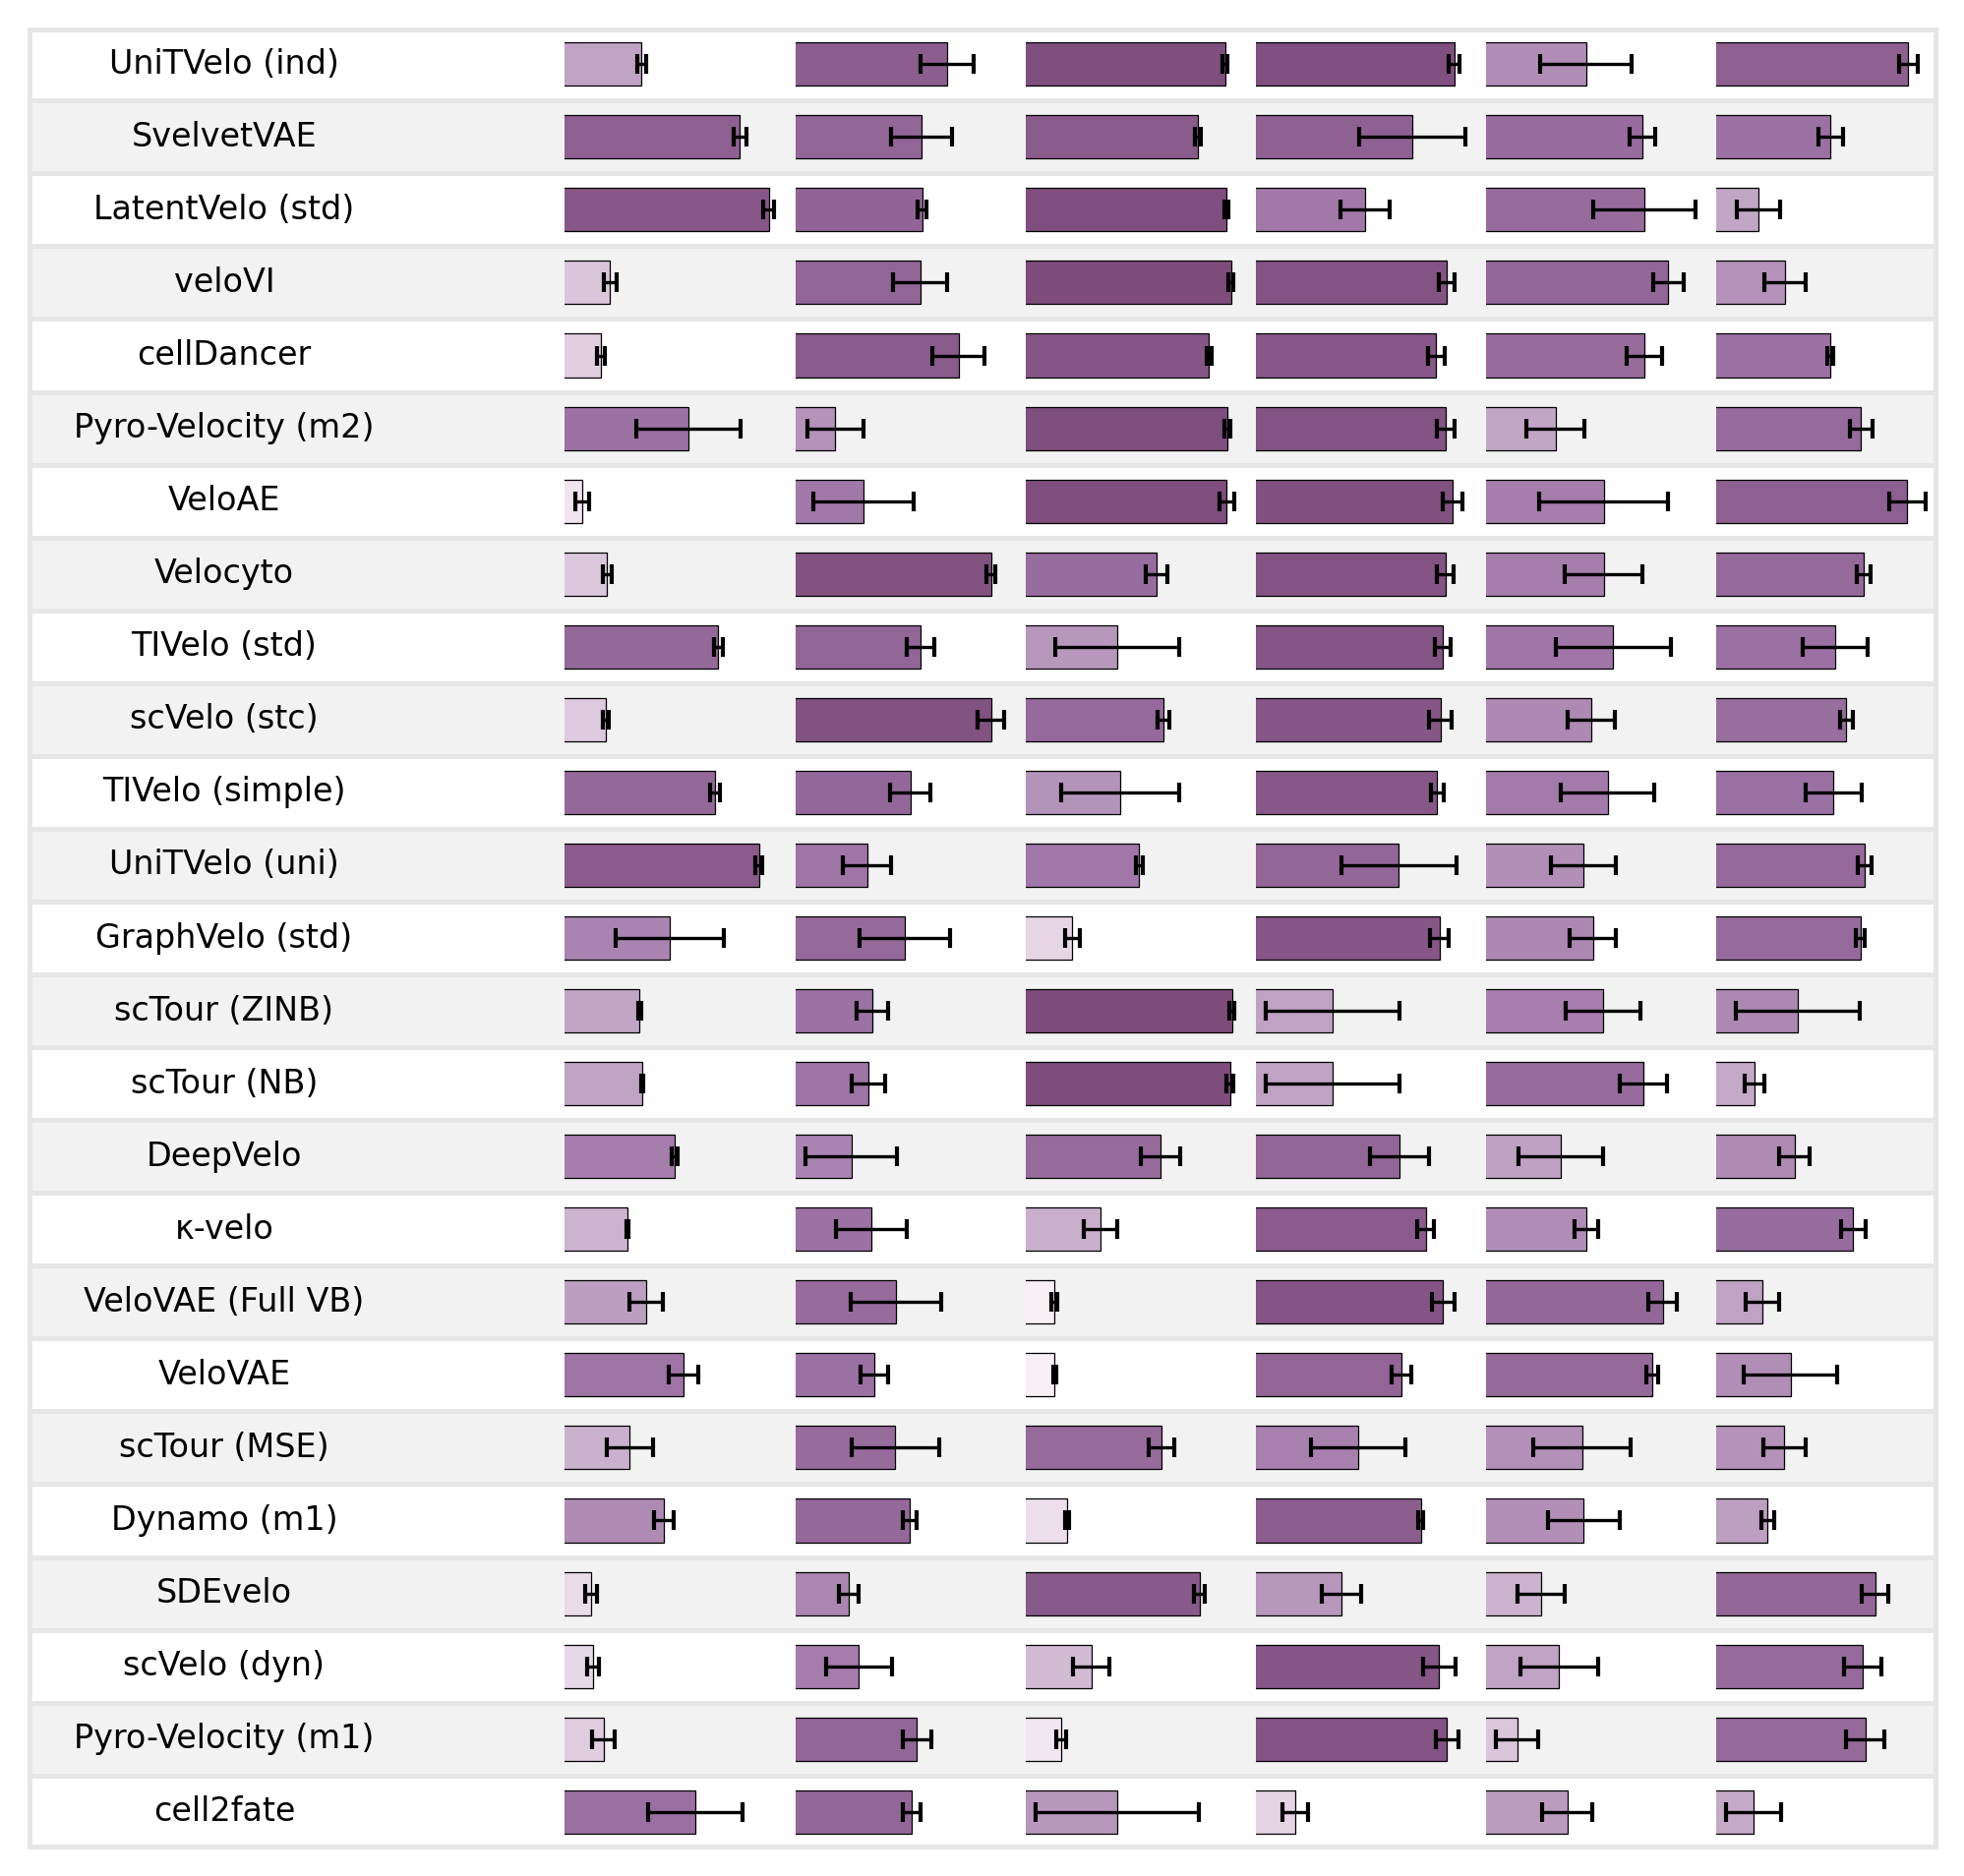

In [31]:
colors = ["#f9f0f6", "#9c72a4", "#7d4c7b"]
fig, ax = plot_method_dataset_bubble(
    concat_df,
    method_order=method_order,
    dataset_order = ['Data 1', 'Data 2', 'Data 3', 'Data 4', 'Data 5', 'Data 6'],
    figsize=(7, 8),
    size_transform="sqrt",
    size_clip=(0.05, 0.95),
    size_min=30, size_max=300,
    row_stripes=True,
    stripe_light=1,
    stripe_contrast=0.05,
    column_spacing=1,
    size_domain=(0.0, 0.65),
    colors=colors,
    bar_outline=True,
)
plt.tight_layout()
plt.savefig("cbdir_barplot.svg", format="svg", bbox_inches="tight", dpi=300)
plt.show()

In [32]:
metric_name = 'icvcoh'
all_scores = []
for dataset in datasets:
    df = pd.read_csv(Path(dataset) / f"{metric_name}_df.csv")
    if metric_name == 'cbdir':
        df.iloc[:, 1:] = (df.iloc[:, 1:] + 1) / 2 
    df_mean_std = df.copy()
    df_mean_std["dataset_mean"] = df_mean_std.iloc[:, 1:].mean(axis=1)
    df_mean_std["dataset_std"] = df_mean_std.iloc[:, 1:].std(axis=1)
    df_mean_std = df_mean_std[["Method", "dataset_mean", "dataset_std"]]
    df_mean_std["dataset"] = dataset
    all_scores.append(df_mean_std)
concat_df = pd.concat(all_scores, ignore_index=True)
concat_df["Method"] = concat_df["Method"].map(method_rename_dict)
concat_df["dataset"] = concat_df["dataset"].map(dataset_rename_dict)
overall_mean = (
    concat_df.groupby("Method")["dataset_mean"]
    .mean()
    .reset_index()
    .rename(columns={"dataset_mean": "overall_mean"})
)
overall_mean['rank'] = overall_mean['overall_mean'].rank(ascending=False)

method_order = (
    overall_mean.sort_values(by="overall_mean", ascending=False)["Method"]
    .tolist()
)

/tmp/ipykernel_83413/2362084064.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


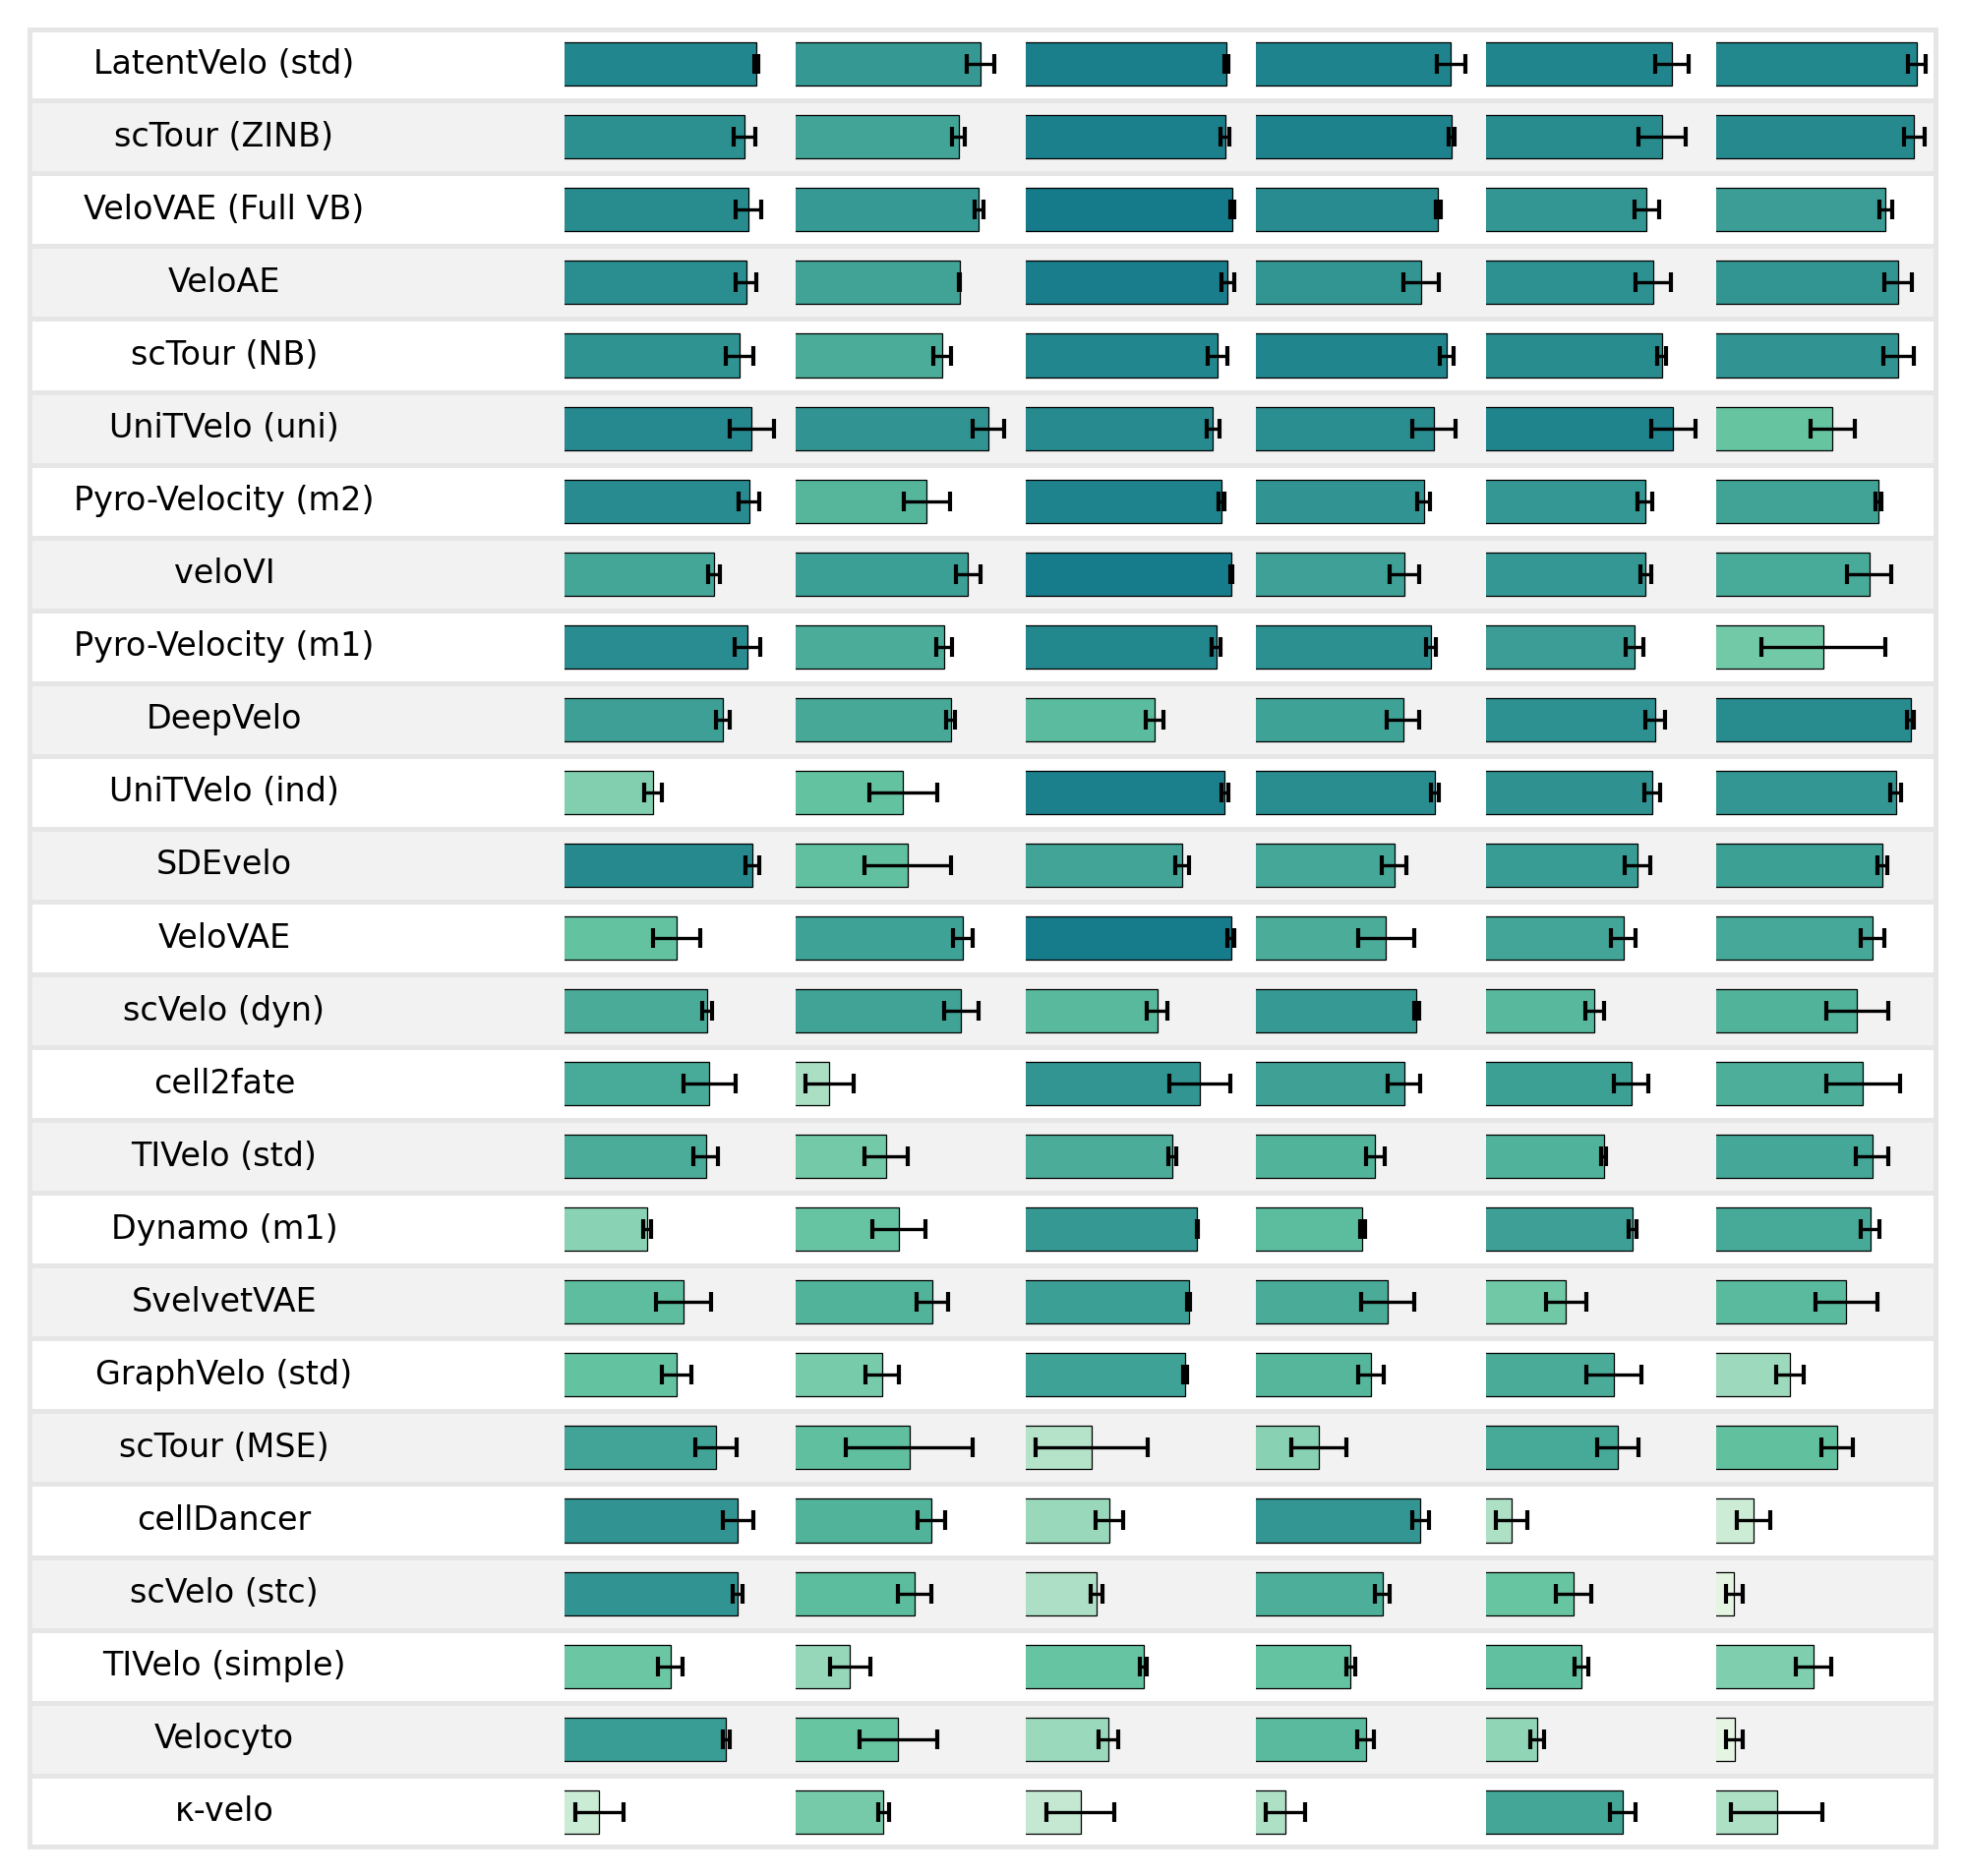

In [33]:
colors = ["#e4f5e1", "#63c3a0", "#157a8a"]
fig, ax = plot_method_dataset_bubble(
    concat_df,
    method_order=method_order,
    dataset_order = ['Data 1', 'Data 2', 'Data 3', 'Data 4', 'Data 5', 'Data 6'],
    figsize=(7, 8),
    size_transform="sqrt",
    size_clip=(0.05, 0.95),
    size_min=30, size_max=300,
    row_stripes=True,
    stripe_light=1,
    stripe_contrast=0.05,
    column_spacing=1,
    size_domain=(0.0, 0.65),
    colors=colors,
    bar_outline=True,
)
plt.tight_layout()
plt.savefig("icvcoh_barplot.svg", format="svg", bbox_inches="tight", dpi=300)
plt.show()

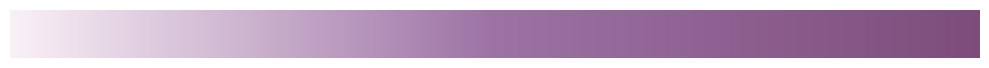

In [34]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

colors = ["#f9f0f6", "#9c72a4", "#7d4c7b"]
# colors = ["#e4f5e1", "#63c3a0", "#157a8a"]
cmap_obj = LinearSegmentedColormap.from_list("custom", colors, N=256)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = mpl.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
sm.set_array([])
fig, ax = plt.subplots(figsize=(10, 8))
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.5, pad=0.01)
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.set_ticklabels([])
ax.remove()
plt.tight_layout()
# plt.savefig("colorbar_cbdir.svg", format="svg", bbox_inches="tight", dpi=300)
plt.show()


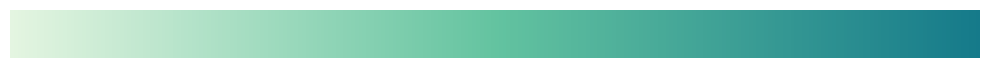

In [35]:
# colors = ["#f9f0f6", "#9c72a4", "#7d4c7b"]
colors = ["#e4f5e1", "#63c3a0", "#157a8a"]
cmap_obj = LinearSegmentedColormap.from_list("custom", colors, N=256)
norm = mpl.colors.Normalize(vmin=0, vmax=1)
sm = mpl.cm.ScalarMappable(cmap=cmap_obj, norm=norm)
sm.set_array([])
fig, ax = plt.subplots(figsize=(10, 8))
cbar = plt.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.5, pad=0.01)
cbar.outline.set_visible(False)
cbar.set_ticks([])
cbar.set_ticklabels([])
ax.remove()
plt.tight_layout()
# plt.savefig("colorbar_icvcoh.svg", format="svg", bbox_inches="tight", dpi=300)
plt.show()

Streamline plot

In [43]:
from pathlib import Path
import os
import scanpy as sc
from scipy.sparse import issparse
import scvelo as scv
dataset = "data01"
methods = ["unitvelo_ind", "celldancer","velovi", "unitvelo_uni"]

In [44]:
umap_colors = [
    "#a8a8ab",  # deep blue
    "#a8a8ab",  # deep red
    "#5b7e91",  # rich green
    "#a0d8ef",  # muted purple
    "#006e54",  # brown
    "#e6b422",  # rose
    "#a8a8ab",  # medium gray
    "#a8a8ab",  # olive yellow
    "#a8a8ab",  # teal
    "#a8a8ab",   # orange
]

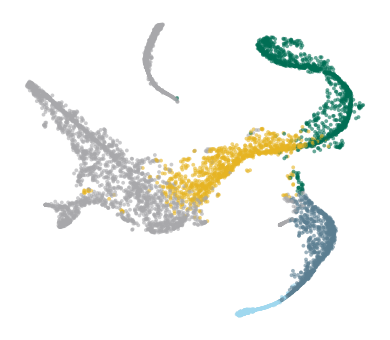

In [45]:
cluster_key = 'clusters'
for method in [methods[0]]:
    adata = sc.read_h5ad(Path(dataset) / f"adata_preprocessed_full.h5ad")
    adata.uns[f'{cluster_key}_colors'] = umap_colors
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
    cluster_order = adata.obs[cluster_key].cat.categories
    cell_types = adata.obs[cluster_key].values
    unique_types = np.unique(cell_types)
    color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
    adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]
    fig, ax = plt.subplots(figsize=(4, 3.5))
    sc.pl.tsne(
        adata,
        color=cluster_key,
        palette=color_map,
        alpha = 0.6,
        title='',
        legend_loc='none',
        ax=ax,
        size=30,
        show=False,
    )
    ax.set_title('')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{dataset}_embedding.png", bbox_inches='tight', dpi=300)
    plt.show()

computing velocity graph (using 20/24 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:10) --> added 
    'unitvelo_ind_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_ind_velocity_tsne', embedded velocity vectors (adata.obsm)


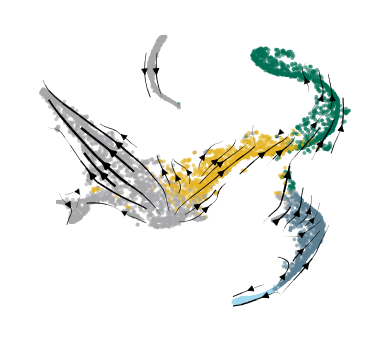

computing velocity graph (using 20/24 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'celldancer_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'celldancer_velocity_tsne', embedded velocity vectors (adata.obsm)


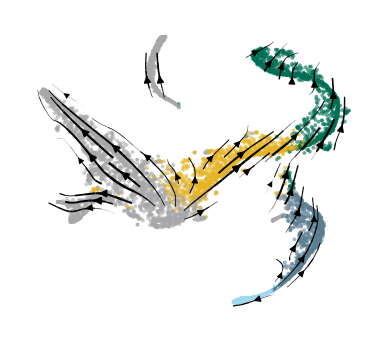

computing velocity graph (using 20/24 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:05) --> added 
    'velovi_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velovi_velocity_tsne', embedded velocity vectors (adata.obsm)


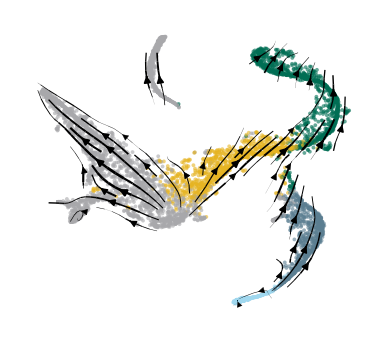

computing velocity graph (using 20/24 cores)


  0%|          | 0/5780 [00:00<?, ?cells/s]

    finished (0:00:07) --> added 
    'unitvelo_uni_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_uni_velocity_tsne', embedded velocity vectors (adata.obsm)


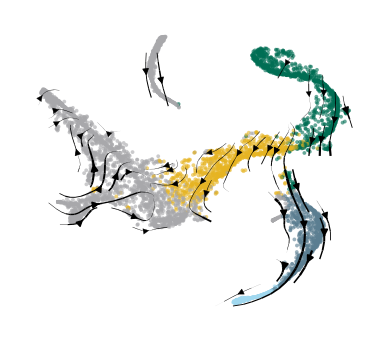

In [ ]:
cluster_key = 'clusters'
old_adata = sc.read_h5ad(Path(dataset) / f"adata_preprocessed_full.h5ad")
for method in methods:
    vkey = f"{method}_velocity"

    adata = sc.read_h5ad(Path(dataset) / f"adata_run_{method}_full.h5ad")
    if issparse(adata.layers[vkey]):
        adata.layers[vkey] = adata.layers[vkey].toarray().astype(np.float32)
    adata.layers[vkey] = np.where(np.isnan(adata.layers[vkey]), 0, adata.layers[vkey])
    sqrt_transform = False
    if method in ["unitvelo_ind", "unitvelo_uni"]:
        sqrt_transform = True
    
    scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=sqrt_transform,n_jobs=20)

    adata.uns[f'{cluster_key}_colors'] = umap_colors
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
    cluster_order = adata.obs[cluster_key].cat.categories
    cell_types = adata.obs[cluster_key].values
    unique_types = np.unique(cell_types)
    color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
    adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]
    kwargs = dict(
        frameon=True, add_margin=.1,density=1,linewidth=1,
        size=30,alpha = 0.6,
    )

    # atac size = 120

    fig, ax = plt.subplots(figsize=(4, 3.5))
    scv.pl.velocity_embedding_stream(
        adata,
        color=cluster_key,
        vkey=vkey,
        basis='tsne',
        title='',
        # legend_loc = 'upper right',
        legend_loc='none',
        ax=ax,
        **kwargs,
        show=False
    )
    ax.set_title('')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{method}_{dataset}_stream.png", bbox_inches='tight', dpi=300)
    plt.show()

In [49]:
from pathlib import Path
import os
import scanpy as sc
from scipy.sparse import issparse
import scvelo as scv
dataset = "data03"
methods = ["unitvelo_ind", "celldancer","velovi", "unitvelo_uni"]

In [50]:
umap_colors = [
    "#c8b0b7", "#b88e8d", "#8e7caf", "#7973c0", "#4c5698"
]

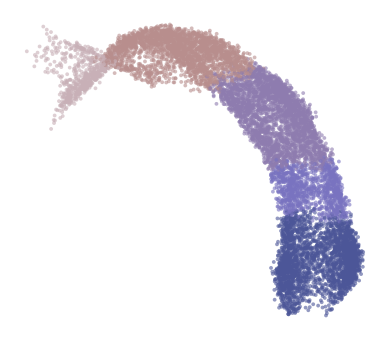

In [54]:
cluster_key = 'celltype'
old_adata = sc.read_h5ad(Path(dataset) / "gastrulation_erythroid.h5ad")
for method in [methods[0]]:
    adata = sc.read_h5ad(Path(dataset) / f"adata_preprocessed_full.h5ad")
    adata.uns[f'{cluster_key}_colors'] = umap_colors
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
    cluster_order = adata.obs[cluster_key].cat.categories
    cell_types = adata.obs[cluster_key].values
    unique_types = np.unique(cell_types)
    color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
    adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]
    fig, ax = plt.subplots(figsize=(4, 3.5))

    umap_old = old_adata.obsm["X_umap"]
    cells = adata.obs_names
    umap_new = umap_old[old_adata.obs_names.get_indexer(cells), :]
    adata.obsm["X_umap"] = umap_new

    sc.pl.umap(
        adata,
        color=cluster_key,
        palette=color_map,
        alpha = 0.6,
        title='',
        legend_loc='none',
        ax=ax,
        size=30,
        show=False,
    )
    ax.set_title('')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{dataset}_embedding.png", bbox_inches='tight', dpi=300)
    plt.show()

computing velocity graph (using 20/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:11) --> added 
    'unitvelo_ind_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_ind_velocity_umap', embedded velocity vectors (adata.obsm)


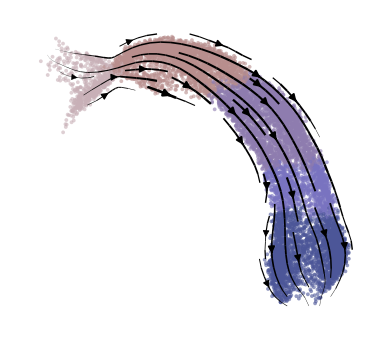

computing velocity graph (using 20/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:16) --> added 
    'celldancer_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'celldancer_velocity_umap', embedded velocity vectors (adata.obsm)


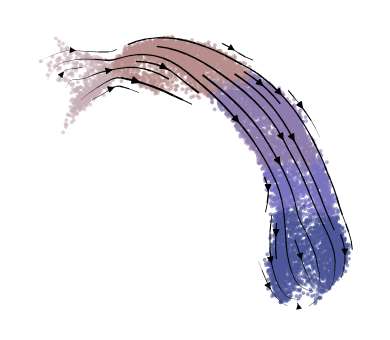

computing velocity graph (using 20/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:14) --> added 
    'velovi_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velovi_velocity_umap', embedded velocity vectors (adata.obsm)


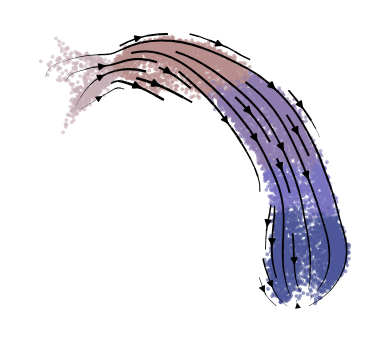

computing velocity graph (using 20/24 cores)


  0%|          | 0/9815 [00:00<?, ?cells/s]

    finished (0:00:18) --> added 
    'unitvelo_uni_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'unitvelo_uni_velocity_umap', embedded velocity vectors (adata.obsm)


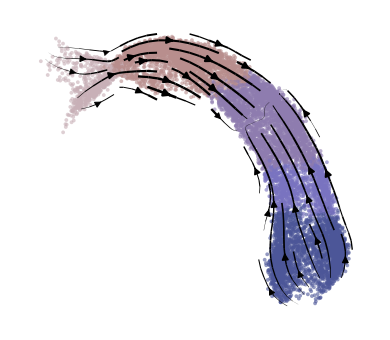

In [56]:
cluster_key = 'celltype'
old_adata = sc.read_h5ad( Path(dataset) / "gastrulation_erythroid.h5ad")
for method in methods:
    vkey = f"{method}_velocity"

    adata = sc.read_h5ad(Path(dataset) / f"adata_run_{method}_full.h5ad")
    if issparse(adata.layers[vkey]):
        adata.layers[vkey] = adata.layers[vkey].toarray().astype(np.float32)
    adata.layers[vkey] = np.where(np.isnan(adata.layers[vkey]), 0, adata.layers[vkey])
    sqrt_transform = False
    if method in ["unitvelo_ind", "unitvelo_uni"]:
        sqrt_transform = True
    
    scv.tl.velocity_graph(adata, vkey=vkey, sqrt_transform=sqrt_transform,n_jobs=20)

    adata.uns[f'{cluster_key}_colors'] = umap_colors
    adata.obs[cluster_key] = adata.obs[cluster_key].astype("category")
    cluster_order = adata.obs[cluster_key].cat.categories
    cell_types = adata.obs[cluster_key].values
    unique_types = np.unique(cell_types)
    color_map = {ct: umap_colors[i % len(umap_colors)] for i, ct in enumerate(unique_types)}
    adata.uns[f'{cluster_key}_colors'] = [color_map[c] for c in cluster_order]
    kwargs = dict(
        frameon=True, add_margin=.1,density=1,linewidth=1,
        size=30,alpha = 0.6,
    )

    # atac size = 120
    umap_old = old_adata.obsm["X_umap"]
    cells = adata.obs_names
    umap_new = umap_old[old_adata.obs_names.get_indexer(cells), :]
    adata.obsm["X_umap"] = umap_new

    fig, ax = plt.subplots(figsize=(4, 3.5))
    scv.pl.velocity_embedding_stream(
        adata,
        color=cluster_key,
        vkey=vkey,
        basis='umap',
        title='',
        # legend_loc = 'upper right',
        legend_loc='none',
        ax=ax,
        **kwargs,
        show=False
    )
    ax.set_title('')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(f"{method}_{dataset}_stream.png", bbox_inches='tight', dpi=300)
    plt.show()